In [13]:
import numpy as np
import pandas as pd
#import asyncio
#import aiohttp
import json
import csv
import requests
import time
from cryptodata import get_markets, get_pairs, get_ohlc
import os
import shutil
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows',10)
def Timestamp_from_string(s='31 12 99'):
    #print(time.mktime(time.strptime(s, "%d %m %y")))
    return pd.Timestamp(int(time.mktime(time.strptime(s, "%d %m %y"))), unit='s')

In [47]:
def get_daily_price(asset="btc", api="coinmetrics", data_type="price(usd)", start=0, end=time.time()):
    if (api == "coinmetrics"):
        try:
            url =  "https://coinmetrics.io/api/v1/get_asset_data_for_time_range/"+asset+"/"+data_type
            url = url + "/"+str(int(start)) +"/"+str(int(end))
            r = requests.get(url).json()['result']
            a = pd.DataFrame(r, columns = ['date(utc)',str(asset)+" "+str(data_type)])
            #print(url)
            a[a.columns[0]] = pd.to_datetime(a[a.columns[0]], unit = 's')

            return a
        except:
            print("Error: disfunctional API from Coinmetrics")            
            
    else:
        return 0


def get_assets_from_coimetrics():
    url = 'https://coinmetrics.io/api/v1/get_supported_assets'
    r  = requests.get(url).json()
    return r

def get_whole_market_from_coimetrics():
    assets = get_assets_from_coimetrics()
    market = {}
    print('Assets available:', assets)
    for asset in assets:
        #print('Getting data for',asset)
        market[asset] = get_daily_price(asset)
    return market

def merge_market_data(market, start=Timestamp_from_string('01 01 17')):
    '''merges the market data from the whole market, dumping coins which are too young '''
    assets = list(market.keys())
    #print(assets)
    #print(range(1,len(assets)))
    mkt = market[assets[0]]
    for i in range(1, len(assets)):
        if market[assets[i]]['date(utc)'][0] < start:
            mkt = pd.merge(mkt, market[assets[i]])
    
    return mkt


def get_coins_series(coins,start=Timestamp_from_string('01 01 17').timestamp()):
    returns = get_daily_price(coins[0], start=start)
    for i in range(1,len(coins)):
        returns = pd.merge(returns, get_daily_price(coins[i], start=start))
    return returns

 
def genetic_solver(w,cov,mean):
    size = len(mean)
    lr = .0005
    weights = np.reshape(np.tile(w,size),(size,size) )
    s = np.ones((size,size))*lr/2
    t = np.eye(size)*lr*1.5
    q = weights + t - s
    #a  = np.matmul(mean, q)
    a = np.matmul(q, mean)
    old_mean = np.matmul(mean,w)
    new_mean = a[np.argmin(a)]
    new_weight = q[np.argmin(a)]
    dif = (old_mean-new_mean)/old_mean

    if dif < 0.5 and np.abs(w) == w:
        return genetic_solver(new_weight, cov, mean)
    else:
        return new_weight

def gd_solver(w, cov, mean):
    lr = .005
    grad = np.matmul(cov, w)
    w2 = w + lr*np.matmul(cov,w)
    print(w2.shape)
    #print(np.matmul(cov, w))
    mean_old = np.matmul(np.matmul(w,cov),w)
    mean_new = np.matmul(np.matmul(w2,cov),w2)
    print('mean_old',mean_old)
    print(mean_old.shape)    
    print('mean_new',mean_new)
    print(mean_new.shape)
    if mean_new < mean_old:
        print('aaaaaa')
        return sgd_solver(w,cov,mean)
    else:
        return w

def rate_of_return(df):
    cols = df.columns
    #print(cols)
    if (type(df[cols[0]][0]) == pd.Timestamp):
        a = df[cols[1:]].values
        b = a/a[0, :]
        df2 = pd.DataFrame(b, columns = df.columns[1:])
        #df2 = pd.merge(df2, pd.Dataframe(b, columns = cols[1:]))
        #print(b)
        
        return df2
    else:
        print('error return_from_values')

    

In [4]:
def load_single_offline_data(coin, path = ""):
    a = pd.read_csv(path + '/'+coin +'.csv', index_col = False, 
                    infer_datetime_format=True, 
                    decimal = ',', parse_dates = [0])
    a = a[['date','price(USD)']]
    a['price(USD)'] = a['price(USD)'].apply(pd.to_numeric)
    a = a.rename(index=str,columns={'date':'date', 'price(USD)':coin+'-'+'price(USD)'})
    return a

def get_whole_market_offline(path):
    assets = []
    market = {}
    for asset in os.listdir(path):
        assets.append(asset[:-4]) 
    for asset in assets:
        market[asset] = load_single_offline_data(asset, path)
    return market

def merge_market_data_offline(market, start=Timestamp_from_string('01 01 17')):
    '''merges the market data from the whole market, dumping coins which are too young '''
    assets = list(market.keys())
    #assets = list(market.keys())
    #print(assets)
    #print(range(1,len(assets)))
    
    mkt = market[assets[0]]
    for i in range(1, len(assets)):
        if market[assets[i]]['date'][0] < start:
            #print(market[assets[i]][0])
            #print(np.isnan(market[assets[i]][assets[i]+'-price(USD)'][0] ))
            #if market[assets[i]].isna().any():
            mkt = pd.merge(mkt, market[assets[i]])
    
    return mkt

def get_portfolio_data_from_market_offli
mkt_mu = mkt.mean()
mkt_sigma = mkt.corr()ne(mkt, coins):
    cols = [mkt.columns[0]]
    for coin in coins:
        cols.append(coin+'-price(USD)')
        
    return mkt[cols]

def get_portfolio_data_from_market(mkt, coins):
    cols = [mkt.columns[0]]
    for coin in coins:
        cols.append(coin+' price(usd)')
        
    return mkt[cols]



In [39]:
# para definir as taxas de base podemos obter os dados do mercado inteiro
market = get_whole_market_from_coimetrics()
#print(market)
# e unir todos a partir de uma dada data


Assets available:  ['ada', 'ae', 'aion', 'ant', 'bat', 'bch', 'bnb', 'btc', 'btg', 'btm', 'cennz', 'ctxc', 'cvc', 'dash', 'dcr', 'dgb', 'doge', 'drgn', 'elf', 'eng', 'eos', 'etc', 'eth', 'ethos', 'fun', 'gas', 'gno', 'gnt', 'icn', 'icx', 'kcs', 'knc', 'loom', 'lrc', 'lsk', 'ltc', 'maid', 'mana', 'mtl', 'nas', 'neo', 'omg', 'pay', 'pivx', 'poly', 'powr', 'ppt', 'qash', 'rep', 'rhoc', 'salt', 'snt', 'srn', 'trx', 'usdt', 'ven', 'veri', 'vtc', 'waves', 'wtc', 'xem', 'xlm', 'xmr', 'xvg', 'zec', 'zil', 'zrx']
Getting data for  ada
Getting data for  ae
Getting data for  aion
Getting data for  ant
Getting data for  bat
Getting data for  bch
Getting data for  bnb
Getting data for  btc
Getting data for  btg
Getting data for  btm
Getting data for  cennz
Getting data for  ctxc
Getting data for  cvc
Getting data for  dash
Getting data for  dcr
Getting data for  dgb
Getting data for  doge
Getting data for  drgn
Getting data for  elf
Getting data for  eng
Getting data for  eos
Getting data for  etc


In [225]:
mkt = merge_market_data(market, Timestamp_from_string('01 01 17'))
# montamos um portfolio com as seguintes moedas:
l = ['btc','ltc','eth']


#todas as opções podem ser obtidas em get_assets_from_coimetrics()
#portfolio = get_coins_series(l)

#market = get_whole_market_offline('coinmetrics')
#mkt = merge_market_data_offline(market, Timestamp_from_string('01 01 17'))


#portfolio = mkt[['date', 'btc', 'ltc', 'eth']]
#portfolio
#portfolio = get_portfolio_data_from_market(mkt, l)
portfolio = mkt[mkt.columns[0:6]]

portfolio_returns = rate_of_return(portfolio)
#portfolio_returns = best_returns(mkt_returns, 5)
mkt_returns = rate_of_return(mkt)

portfolio_returns
#mkt_returns

,ada price(usd),btc price(usd),dash price(usd),dcr price(usd),dgb price(usd)
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.135114,1.012614,0.966356,0.959698,1.148438
2,1.188163,1.015529,0.943753,0.988982,1.012068
3,0.962450,0.995006,0.907601,0.915628,0.884273
4,1.012593,0.974391,0.934057,0.894172,0.862170
...,...,...,...,...,...
298,7.953501,1.883611,0.747362,1.926645,2.853277
299,7.586032,1.831446,0.740174,1.862279,2.642848
300,7.668051,1.881817,0.746475,1.860249,2.770008
301,7.572793,1.890285,0.737972,1.880545,2.754637


In [ ]:
# geramos 1000 porfolios de forma aleatória:
L = 10000
s = np.zeros(L)
m = np.zeros(L)



mu = portfolio_returns.mean()
sigma = portfolio_returns.corr()
#sigma = portfolio_returns.cov()
mkt_mu = mkt_returns.mean()
mkt_sigma = mkt_returns.corr()
#mkt_sigma = mkt_returns.cov()
print('mkt_mu.shape',mkt_mu.shape)

sim_data = {}
for i in range(L):
    
    w1 = np.random.rand(mu.shape[0])
    w2 = np.sum(w1)
    w = w1/w2
    m[i] = np.matmul(mu, w)
    s[i] = np.sqrt( np.matmul(np.matmul(w, sigma), w) )
    sim_data[tuple(w)] = (m[i], s[i], m[i]/s[i], m[i]/(s[i]*s[i]))
    

k = np.arange(0,2.1,.1)

mkt_cols = mkt.shape[1]-1
points = 30
print('mkt_cols',mkt_cols)
mkt_w = np.reshape(np.tile(np.ones(mkt_cols)/mkt_cols , points   ), (points, mkt_cols) )

mkt_m = []
mkt_s = []
for k in range(1000,1100):
    mkt_w = np.ones(mkt_cols)*k/mkt_cols/1000
    #print('mkt_w.shape',mkt_w.shape)
    mkt_m.append(np.matmul(mkt_w, mkt_mu))
    #print('mkt_sigma.shape',mkt_sigma.shape)
    mkt_s.append(np.sqrt(np.matmul(np.matmul(mkt_w, mkt_sigma), mkt_w)))


# fazemos um gráfico desses portfolios aleatórios
plt.scatter(s,m,1,'b')
#plt.scatter(mkt_s, mkt_m,1,'r')
plt.ylabel('returns')
plt.xlabel('risk')
plt.show()

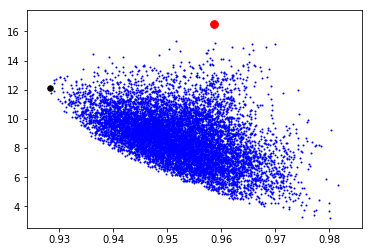

In [224]:
sharpe = -100
min_risk = 100
for w in list(sim_data):
    temp_sharpe = sim_data[w][2]
    if temp_sharpe > sharpe:
        wmax = w
        sharpe = temp_sharpe
        #print(sharpe)
    temp_risk = sim_data[w][1]
    if temp_risk < min_risk :
        min_risk = temp_risk
        wmin = w
    

plt.scatter(s,m,1,'b')
plt.scatter(sim_data[wmax][1], sim_data[wmax][0], 60,'r')
plt.scatter(sim_data[wmin][1], sim_data[wmin][0], 30,'k')
        

In [118]:
mkt.columns[1:10]


Index(['ada price(usd)', 'btc price(usd)', 'dash price(usd)', 'dcr price(usd)',
       'dgb price(usd)', 'doge price(usd)', 'etc price(usd)', 'eth price(usd)',
       'gnt price(usd)'],
      dtype='object')

In [214]:
def worst_returns(mkt, num = 5):

    a = np.array(mkt.iloc[-1])
    b = np.argsort(a)
    worst = []
    for t in b:
        if t < num:
            worst.append(mkt.columns[b[t]])
        
    return mkt[worst]

def best_returns(mkt, num = 5):

    a = np.array(mkt.iloc[-1])
    b = np.argsort(a)
    best = []
    for t in b:
        if t > b.shape[0] -1 - num:
            best.append(mkt.columns[b[t]])
        
    return mkt[best]


best_returns(mkt_returns, 5)


,dgb price(usd),xlm price(usd),xvg price(usd),ada price(usd),doge price(usd)
0,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.148438,0.991602,1.024166,1.135114,0.941331
2,1.012068,0.937305,1.033947,1.188163,0.950088
3,0.884273,0.902700,0.973820,0.962450,0.981611
4,0.862170,0.860132,0.913982,1.012593,0.889667
...,...,...,...,...,...
298,2.853277,24.057265,3.504171,7.953501,3.091068
299,2.642848,22.318323,3.312140,7.586032,2.966725
300,2.770008,23.006443,3.390535,7.668051,2.984238
301,2.754637,22.906031,3.411105,7.572793,2.989492
